In [1]:
import ROOT
import uproot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.22/08


In [351]:
mstop_175   = pd.read_pickle('DNN_ips/SUSY_Mstop_175_mchi_7_5.pkl')
mstop_182_5 = pd.read_pickle('DNN_ips/SUSY_Mstop_182_5_mchi_7_5.pkl')
mstop_190   = pd.read_pickle('DNN_ips/SUSY_Mstop_190_mchi_7_5.pkl')

mstop_227_5 = pd.read_pickle('DNN_ips/SUSY_Mstop_227_5_mchi_60.pkl')
mstop_235   = pd.read_pickle('DNN_ips/SUSY_Mstop_235_mchi_60.pkl')
mstop_242_5 = pd.read_pickle('DNN_ips/SUSY_Mstop_242_5_mchi_60.pkl')

tt_df     = pd.read_pickle('DNN_ips/ttbar.pkl')
st_df     = pd.read_pickle('DNN_ips/Single_top.pkl')
vv_df     = pd.read_pickle('DNN_ips/VV.pkl')

In [336]:
tt_df.columns

Index(['lepton_pt', 'lepton_eta', 'lepton_phi', 'sublepton_pt',
       'sublepton_eta', 'sublepton_phi', 'ljet_pt', 'ljet_eta', 'ljet_phi',
       'sljet_pt', 'sljet_eta', 'sljet_phi', 'llbar_dphi', 'llbar_deta',
       'bbbar_dphi', 'bbbar_deta', 'MET', 'HT', 'ST'],
      dtype='object')

In [354]:
tt_df['llbar_new']     = tt_df['lepton_eta']     - tt_df['sublepton_eta']
mstop_175['llbar_new'] = mstop_175['lepton_eta'] - mstop_175['sublepton_eta']

In [355]:
#selected_columns = ['lepton_pt', 'lepton_eta', 'lepton_phi', 'sublepton_pt',
       #'sublepton_eta', 'sublepton_phi', 'llbar_dphi', 'llbar_deta',
       #'MET', 'HT']
        
selected_columns = ['lepton_eta', 'sublepton_eta', 'llbar_new']

#selected_columns = ['llbar_dphi', 'llbar_deta','MET', 'HT']

In [356]:
sig_df = mstop_175[selected_columns]
tt_df  = tt_df[selected_columns]

In [340]:
sig_df = sig_df.sample(frac=1)
tt_df  = tt_df.sample(frac=1)

In [341]:
sig_df_train = sig_df[1:50000]
tt_df_train  = tt_df[1:50000]

In [342]:
# Standardize
sig_mean = sig_df_train.mean()
sig_std  = sig_df_train.std()

tt_mean = tt_df_train.mean()
tt_std  = tt_df_train.std()

sig_df_train = (sig_df_train - sig_mean)/ sig_std
tt_df_train  = (tt_df_train  - tt_mean)/ tt_std

In [343]:
sig_df_test = sig_df[50000:]
tt_df_test  = tt_df[50000:]

In [344]:
# Standardize
sig_mean = sig_df_test.mean()
sig_std  = sig_df_test.std()

tt_mean = tt_df_test.mean()
tt_std  = tt_df_test.std()

sig_df_test = (sig_df_test - sig_mean)/ sig_std
tt_df_test  = (tt_df_test  - tt_mean)/ tt_std

In [345]:
bkgList = [tt_df_train]  # List of your dataframes

bkg_df_train = pd.concat(bkgList)

signal    = sig_df_train.values
bkg       = bkg_df_train.values

sig_label = np.ones(len(signal))
bkg_label = np.zeros(len(bkg))

data      = np.concatenate((signal,bkg))
label     = np.concatenate((sig_label,bkg_label))

In [346]:
test_signal    = sig_df_test.values
test_bkg       = tt_df_test.values

test_sig_label = np.ones(len(test_signal))
test_bkg_label = np.zeros(len(test_bkg))

test_data      = np.concatenate((test_signal,test_bkg))
test_label     = np.concatenate((test_sig_label,test_bkg_label))

In [347]:
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout , BatchNormalization
from skopt        import gp_minimize

model = Sequential()
model.add(Dense(15, input_dim = 3 ,activation='relu'))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())
#model.add(Dense(150, input_dim = 150 ,activation='relu'))
#model.add(Dropout(0.4))
#model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 15)                60        
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 16        
Total params: 76
Trainable params: 76
Non-trainable params: 0
_________________________________________________________________


In [308]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [348]:
hist = model.fit(data, label, batch_size=50, epochs=100,verbose=1, shuffle=True, validation_split=0.20,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),
                  ModelCheckpoint(filepath='model.h5', verbose=0)])

Epoch 1/100
1600/1600 [==============================] - 2s 1ms/step - loss: 0.6681 - accuracy: 0.5993 - val_loss: 0.9547 - val_accuracy: 0.0000e+00
Epoch 2/100
1600/1600 [==============================] - 2s 1ms/step - loss: 0.6481 - accuracy: 0.6268 - val_loss: 0.9159 - val_accuracy: 0.0234
Epoch 3/100
1600/1600 [==============================] - 2s 1ms/step - loss: 0.6369 - accuracy: 0.6289 - val_loss: 0.9211 - val_accuracy: 7.0000e-04
Epoch 4/100
1600/1600 [==============================] - 2s 957us/step - loss: 0.6238 - accuracy: 0.6302 - val_loss: 0.8993 - val_accuracy: 0.0461
Epoch 5/100
1600/1600 [==============================] - 2s 961us/step - loss: 0.6042 - accuracy: 0.6435 - val_loss: 0.8824 - val_accuracy: 0.0380
Epoch 6/100
1600/1600 [==============================] - 2s 942us/step - loss: 0.5823 - accuracy: 0.6648 - val_loss: 0.8397 - val_accuracy: 0.1408
Epoch 7/100
1600/1600 [==============================] - 2s 971us/step - loss: 0.5523 - accuracy: 0.7103 - val_loss:

1600/1600 [==============================] - 1s 808us/step - loss: 0.0504 - accuracy: 0.9878 - val_loss: 0.0730 - val_accuracy: 0.9686
Epoch 57/100
1600/1600 [==============================] - 1s 735us/step - loss: 0.0494 - accuracy: 0.9881 - val_loss: 0.0793 - val_accuracy: 0.9620
Epoch 58/100
1600/1600 [==============================] - 1s 837us/step - loss: 0.0487 - accuracy: 0.9874 - val_loss: 0.0672 - val_accuracy: 0.9718
Epoch 59/100
1600/1600 [==============================] - 1s 737us/step - loss: 0.0466 - accuracy: 0.9884 - val_loss: 0.0563 - val_accuracy: 0.9797
Epoch 60/100
1600/1600 [==============================] - 1s 744us/step - loss: 0.0464 - accuracy: 0.9887 - val_loss: 0.0703 - val_accuracy: 0.9682
Epoch 61/100
1600/1600 [==============================] - 1s 739us/step - loss: 0.0452 - accuracy: 0.9880 - val_loss: 0.0707 - val_accuracy: 0.9685
Epoch 62/100
1600/1600 [==============================] - 1s 732us/step - loss: 0.0454 - accuracy: 0.9884 - val_loss: 0.0752 

In [181]:
import matplotlib.pyplot as plt
def show_losses( histories ):
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch', fontsize=17)
    plt.ylabel('Loss' , fontsize=17)
    plt.tick_params(axis="y", labelsize=15)
    plt.tick_params(axis="x", labelsize=15)
    plt.title('Cross Entropy Loss by Epoch', fontsize=17)
    color='C0'
    do_acc=False
    for label,loss in histories:
        #color = tuple(np.random.random(3))
        #colors.append(color)
        l = 'Training set loss'
        vl= 'Validation set loss'
        if 'accuracy' in loss.history:
            l+=' (acc %2.4f)'% (loss.history['accuracy'][-1])
            do_acc = True
        if 'val_accuracy' in loss.history:
            vl+=' (val acc %2.4f)'% (loss.history['val_accuracy'][-1])
            do_acc = True
        plt.plot(loss.history['loss'], label=l, color='C0')
        if 'val_loss' in loss.history:
            plt.plot(loss.history['val_loss'], lw=2, ls='dashed', label=vl, color='C0')

    plt.legend(fontsize=17)
    #plt.yscale('log')
    plt.show()
    
    if not do_acc: return
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch', fontsize=17)
    plt.ylabel('Accuracy' , fontsize=17)
    plt.tick_params(axis="y", labelsize=15)
    plt.tick_params(axis="x", labelsize=15)
    for i,(label,loss) in enumerate(histories):
        #color = colors[i]
        if 'accuracy' in loss.history:
            plt.plot(loss.history['accuracy'], lw=2, label=label+" accuracy", color=color)
        if 'val_accuracy' in loss.history:
            plt.plot(loss.history['val_accuracy'], lw=2, ls='dashed', label=label+" validation accuracy", color=color)
    plt.legend(fontsize=17)
    plt.show()

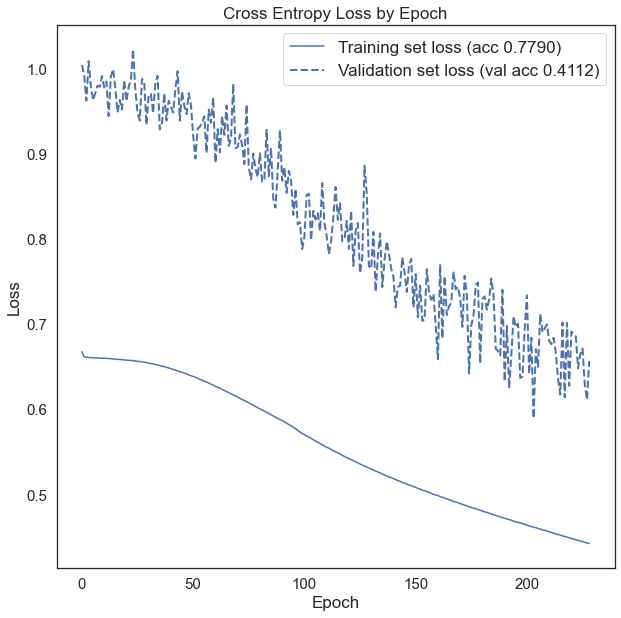

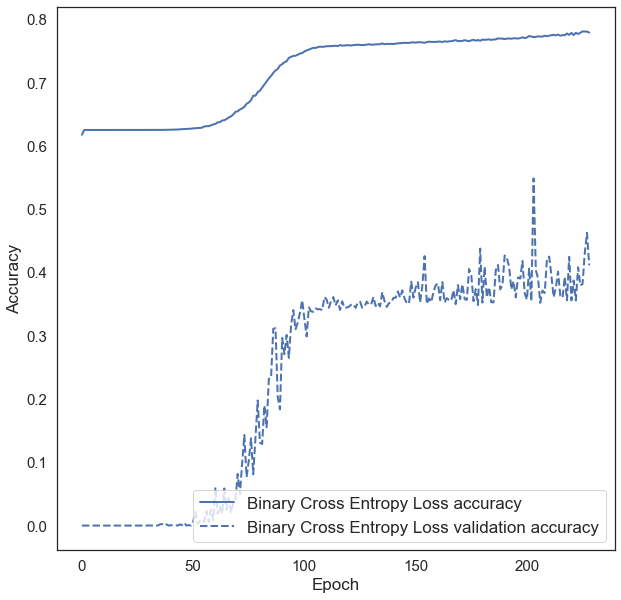

In [310]:
show_losses( [("Binary Cross Entropy Loss", hist)])

In [66]:
from sklearn.metrics import roc_curve
y_pred_train = model.predict(data).ravel()
y_pred_test  = model.predict(test_data).ravel()

fpr_keras_train, tpr_keras_train, thresholds_keras = roc_curve(label, y_pred_train)
fpr_keras_test , tpr_keras_test , thresholds_keras = roc_curve(test_label, y_pred_test)

In [67]:
from sklearn.metrics import auc
auc_keras_test  = auc(fpr_keras_test, tpr_keras_test)
auc_keras_train = auc(fpr_keras_train, tpr_keras_train)

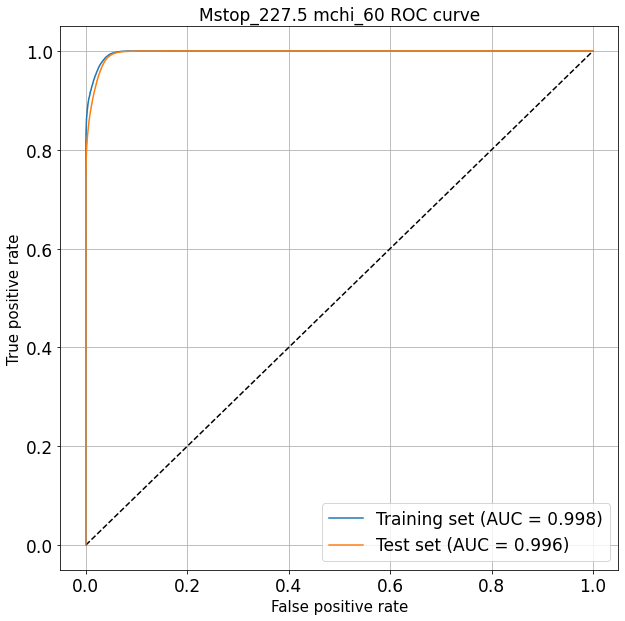

In [68]:
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_train, tpr_keras_train, label='Training set (AUC = {:.3f})'.format(auc_keras_train))
plt.plot(fpr_keras_test , tpr_keras_test , label='Test set (AUC = {:.3f})'.format(auc_keras_test))
plt.tick_params(axis="y", labelsize=17)
plt.tick_params(axis="x", labelsize=17)
plt.xlabel('False positive rate', fontsize=15)
plt.ylabel('True positive rate' , fontsize=15)
plt.title('Mstop_227.5 mchi_60 ROC curve', fontsize=17)
plt.legend(loc='lower right', fontsize=17)
plt.grid()
#plt.savefig('ROC Mstop 227.5 Mchi 60.jpg')
plt.show()

In [334]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_label,np.round(y_pred_test)))
print(classification_report(test_label,np.round(y_pred_test)))

[[1345773  112104]
 [     97   75842]]
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96   1457877
         1.0       0.40      1.00      0.57     75939

    accuracy                           0.93   1533816
   macro avg       0.70      0.96      0.77   1533816
weighted avg       0.97      0.93      0.94   1533816



In [204]:
tt_pred  = model.predict(tt_df_test) 
si_pred  = model.predict(sig_df_test)

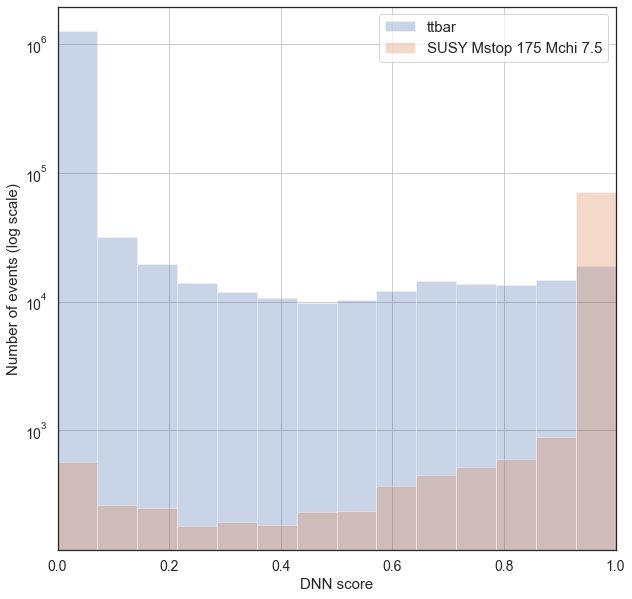

In [205]:
binning = np.linspace(0,1,15)
plt.figure(figsize=(10,10))
plt.tick_params(axis="y", labelsize=14)
plt.tick_params(axis="x", labelsize=14)
plt.hist(tt_pred, bins=binning, alpha=0.3, label='ttbar')
plt.hist(si_pred, bins=binning, alpha=0.3, label='SUSY Mstop 175 Mchi 7.5')
#plt.hist(sat_pred, bins=binning, alpha=0.3, label='Single Antitop')
plt.yscale('log')
plt.xlim(0,1)
plt.xlabel('DNN score', fontsize=15)
plt.ylabel('Number of events (log scale)', fontsize=15)
plt.grid()
plt.legend(loc='best', fontsize=15)
#plt.savefig('DNN_score_Mstop_227_5_Mchi_60.jpg')

NameError: name 'y_train' is not defined

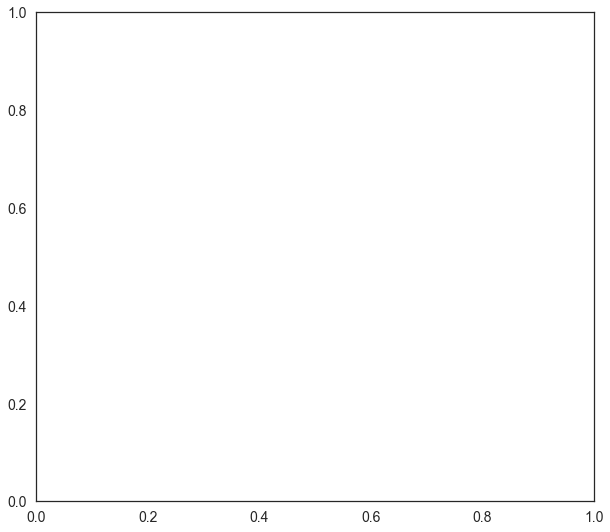

In [185]:
c0 = 'C0'
c1 = 'C1'
binning = np.linspace(0,1,15)
plt.figure(figsize=(10,9))
plt.tick_params(axis="y", labelsize=14)
plt.tick_params(axis="x", labelsize=14)
plt.hist(y_pred_train[y_train == 0], bins=binning, label='SM Training set', histtype='step', linestyle='solid', linewidth=1.5, density=True, color=c0)
plt.hist(y_pred_test[y_test == 0]  , bins=binning, label='SM Test set'    , alpha=0.3, linewidth=1.5, density=True , color=c0)
plt.hist(y_pred_train[y_train == 1], bins=binning, label='SUSY Training set', histtype='step' , linestyle='solid', linewidth=1.5, density=True, color=c1)
plt.hist(y_pred_test[y_test == 1]  , bins=binning, label='SUSY Test set ', alpha=0.3, linewidth=1.5, density=True, color=c1)

plt.yscale('log')
#plt.ylim(0.01, 20)
plt.xlim(0,1)
plt.xlabel('DNN score (Mstop_227.5 Mchi_60)', fontsize=17)
plt.ylabel('Arbitrary units', fontsize=17)
plt.legend(loc='upper center', fontsize=17)
#plt.savefig('Train vs test Mstop_227.5 Mchi_60.jpg')

<ipython-input-39-c75dc0f6f979>:31: RuntimeWarning: divide by zero encountered in true_divide
  ns3 / ns4,  # maybe check for div-by-zero!
<ipython-input-39-c75dc0f6f979>:31: RuntimeWarning: invalid value encountered in true_divide
  ns3 / ns4,  # maybe check for div-by-zero!


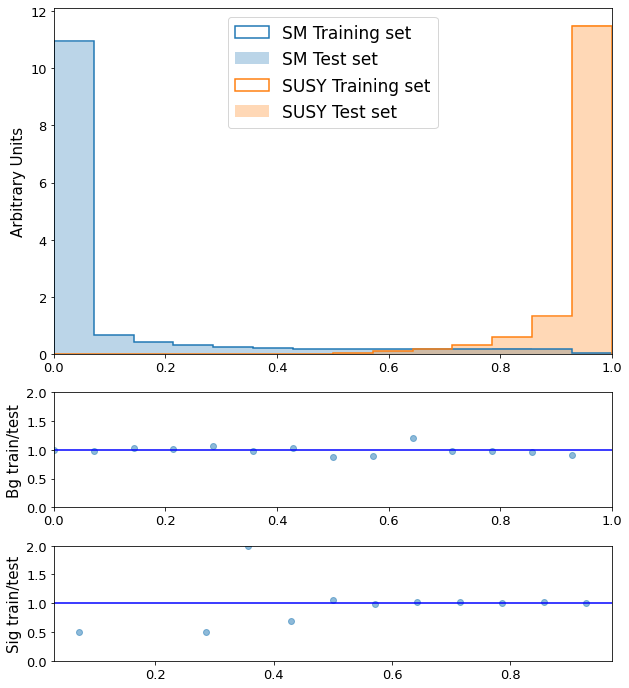

In [39]:
x_low    =  0
x_high   =  1

binning = np.linspace(x_low,x_high, 15)

ratio_fig_style = {
    'figsize': (10, 12),
    'gridspec_kw': {'height_ratios': (3, 1, 1)},
}

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, **ratio_fig_style)

ns1, bins1, patches  = ax1.hist(y_pred_train[y_train == 0], bins=binning, label='SM Training set', histtype='step', linestyle='solid', linewidth=1.5, density=True, color=c0)
ns2, bins2, patches  = ax1.hist(y_pred_test[y_test == 0]  , bins=binning, label='SM Test set'    , alpha=0.3, linewidth=1.5, density=True , color=c0)
ns3, bins3, patches  = ax1.hist(y_pred_train[y_train == 1], bins=binning, label='SUSY Training set', histtype='step' , linestyle='solid', linewidth=1.5, density=True, color=c1)
ns4, bins4, patches  = ax1.hist(y_pred_test[y_test == 1]  , bins=binning, label='SUSY Test set ', alpha=0.3, linewidth=1.5, density=True, color=c1)

ax1.legend(prop={'size': 17}, loc='upper center')
ax1.set_xlim(x_low,x_high)
ax2.scatter(binning[:-1],  # this is what makes it comparable
               ns1 / ns2,  # maybe check for div-by-zero!
                alpha=0.5)

ax1.set_ylabel('Arbitrary Units', fontsize=15)
ax2.set_ylabel('Bg train/test' , fontsize=15)
#ax2.set_xlabel('ttbar mass (GeV)', fontsize=15)
ax2.set_ylim(0, 2)
ax2.set_xlim(x_low,x_high)

ax3.scatter(binning[:-1],  # this is what makes it comparable
               ns3 / ns4,  # maybe check for div-by-zero!
                alpha=0.5)

ax3.set_ylabel('Sig train/test', fontsize=15)
ax3.set_ylim(0, 2)

ax1.tick_params(axis="x", labelsize=13)
ax2.tick_params(axis="x", labelsize=13)
ax3.tick_params(axis="x", labelsize=13)

ax1.tick_params(axis="y", labelsize=13)
ax2.tick_params(axis="y", labelsize=13)
ax3.tick_params(axis="y", labelsize=13)

ax2.axhline(y=1, color='b', linestyle='-')
ax3.axhline(y=1, color='b', linestyle='-')
plt.show()

In [136]:
def CorrMtx(df, dropDuplicates = True):

    # Your dataset is already a correlation matrix.
    # If you have a dateset where you need to include the calculation
    # of a correlation matrix, just uncomment the line below:
    # df = df.corr()
    sns.set(font_scale=1.4)
    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(15, 12))

    # Add diverging colormap from red to blue
    #cmap = sns.diverging_palette(250, 10, as_cmap=True)
    #cmap  = sns.color_palette("coolwarm")
    cmap = sns.diverging_palette(0,255,sep=1, as_cmap=True)
                                 
    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        hm = sns.heatmap(df, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax, vmin=-1, vmax=1)
        plt.title('Correlation matrix for input features', fontsize=30)
        plt.savefig('ip_features_corr.png')
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,          
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax, vmin=-1, vmax=1)

/home/amandeephy/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/amandeephy/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


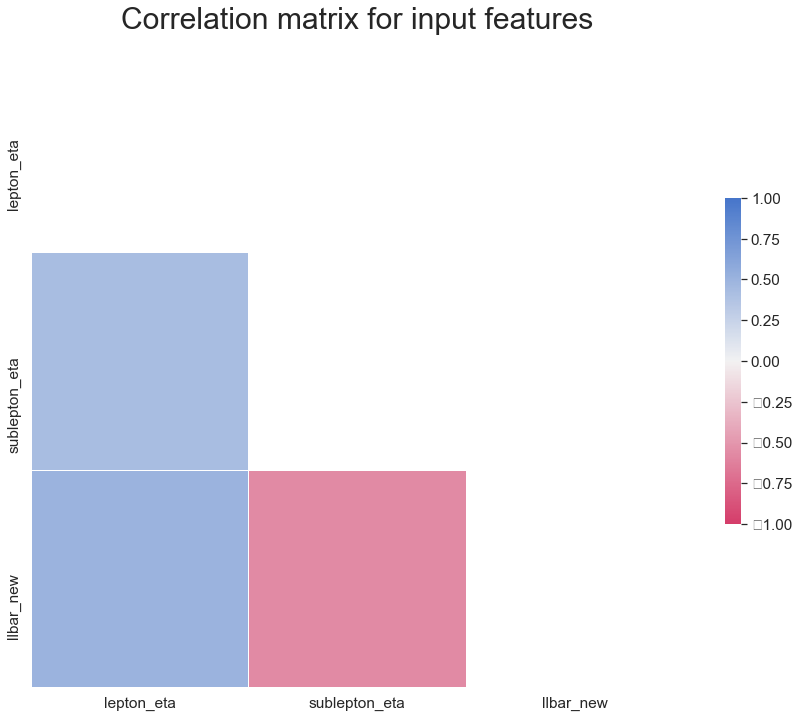

In [294]:
corr = sig_df_train.corr()
CorrMtx(corr, dropDuplicates = True)

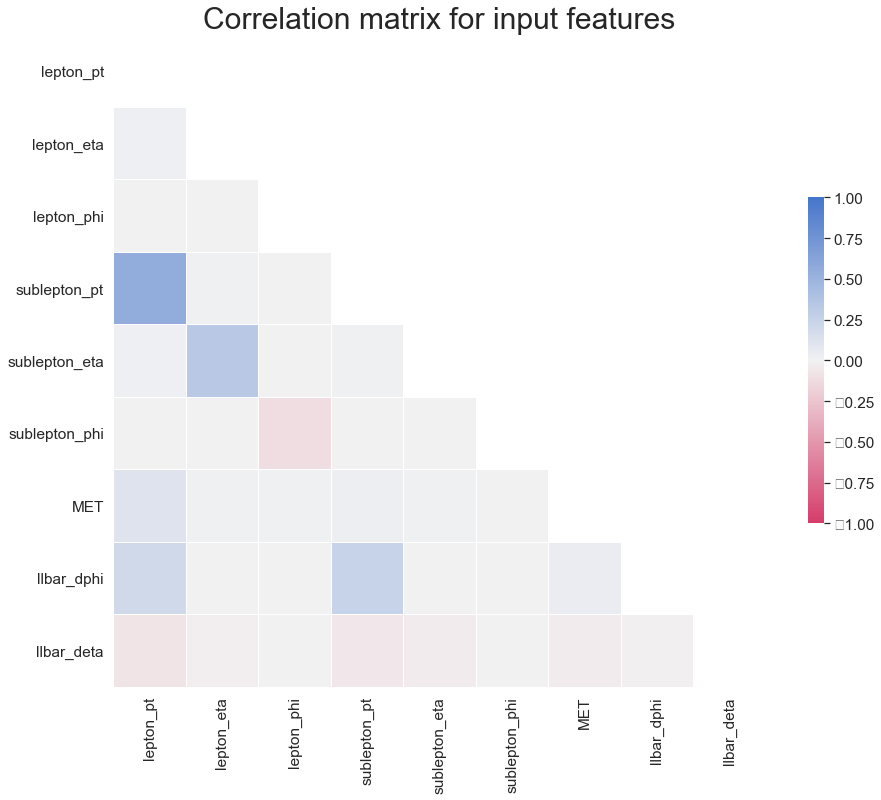

In [138]:
corr = tt_df_train.corr()
CorrMtx(corr, dropDuplicates = True)

In [54]:
from sklearn.decomposition import PCA

In [186]:
import eli5
from   eli5.sklearn import PermutationImportance

from keras.metrics import BinaryAccuracy
from eli5.permutation_importance import get_score_importances

def score(X, y):
    y_pred = model.predict(X).ravel()
    y_true = y.ravel()
    metric = BinaryAccuracy()
    metric.update_state(y_pred, y_true)
    return metric.result().numpy()

base_score, score_decreases = get_score_importances(score, test_data, test_label)
feature_importances         = np.mean(score_decreases, axis = 0)

In [187]:
features = sig_df.columns
for i in range(len(feature_importances)) :
    print('Feature :: ' + str(features[i]) + ' importance :: ' + str(feature_importances[i]))

Feature :: lepton_pt importance :: 0.0006161103
Feature :: lepton_eta importance :: -0.4306931
Feature :: sublepton_pt importance :: 0.0009608714
Feature :: sublepton_eta importance :: -0.431316
Feature :: llbar_deta importance :: -0.35620165


/home/amandeephy/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/amandeephy/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


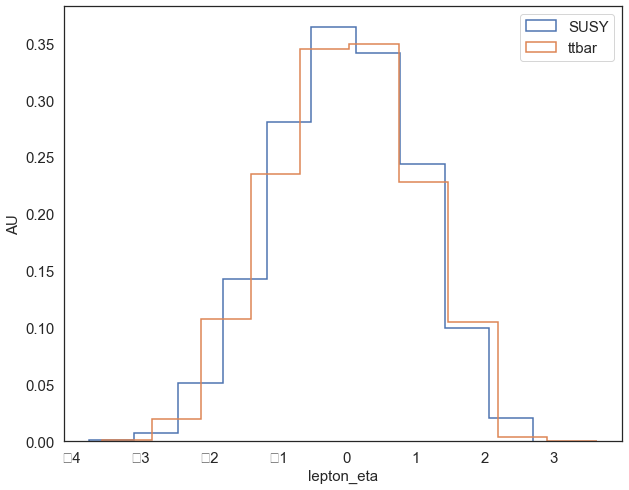

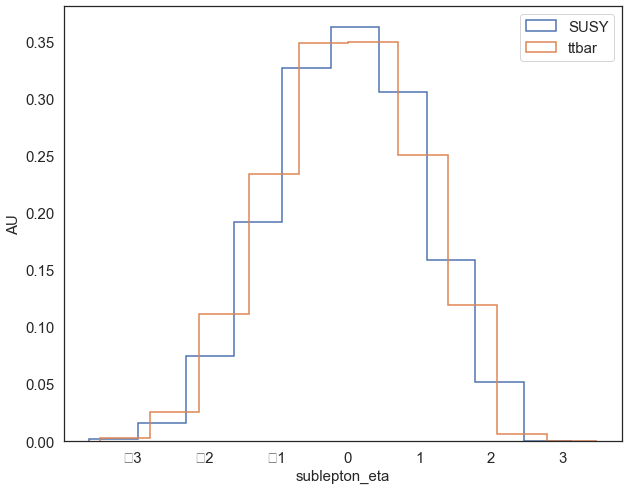

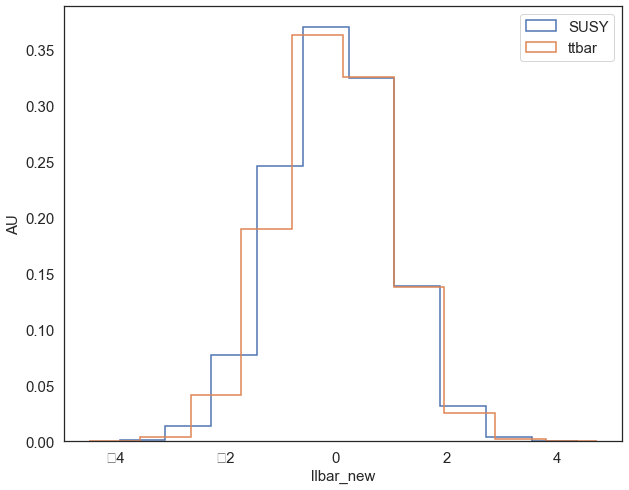

In [295]:
x_labels = sig_df.columns
count    = 0

for i in sig_df.columns :
    plt.figure(figsize=(10,8))
    # Plot the histograms
    plt.hist(sig_df_test[i], histtype='step', density=True, linewidth=1.5, label='SUSY')
    plt.hist(tt_df_test[i] , histtype='step', density=True, linewidth=1.5, label='ttbar')
    
    # Formatting
    plt.xlabel(x_labels[count], fontsize=15)
    plt.ylabel('AU', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(fontsize=15)

    #img_name = 'Images/Mstop_235_' + str(x_labels[count]) + '.jpg' 
    count   += 1
    #plt.savefig(img_name)

In [245]:
def f(x, y):
    return x-y

X = np.array(sig_df['lepton_eta'])
Y = np.array(sig_df['sublepton_eta'])
#X, Y = np.meshgrid(x, y)
Z = np.array(sig_df['llbar_new'])

x1 = tt_df['lepton_eta']
y1 = tt_df['sublepton_eta']
X1, Y1 = np.meshgrid(x1, y1)
Z1 = f(X1,Y1)

'''
def f(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 2))

x = np.linspace(-6, 6, 30)
y = np.linspace(-6, 6, 30)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)
'''

ax = plt.axes(projection='3d')
#ax.view_init(60, 35)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('surface');

MemoryError: Unable to allocate 16.5 TiB for an array with shape (1507877, 1507877) and data type float64

In [258]:
from mpl_toolkits.mplot3d import Axes3D


X = np.array(sig_df.loc[:1000,'lepton_eta'])
Y = np.array(sig_df.loc[:1000,'sublepton_eta'])
Z = np.array(sig_df.loc[:1000,'llbar_new'])

X1 = np.array(tt_df.loc[:1000,'lepton_eta'])
Y1 = np.array(tt_df.loc[:1000,'sublepton_eta'])
Z1 = np.array(tt_df.loc[:1000,'llbar_new'])

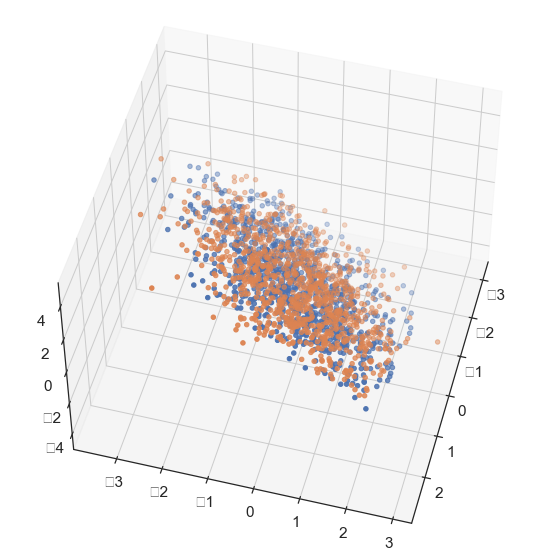

In [275]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X,Y,Z)
ax.scatter(X1,Y1,Z1)
ax.view_init(azim=15, elev=50)
plt.show()

In [357]:
sig_df

,lepton_eta,sublepton_eta,llbar_new
0,1.631996,-0.072351,1.704347
1,-0.502981,-0.962942,0.459961
2,0.397918,0.134825,0.263093
3,1.905253,0.545058,1.360195
4,0.724194,-0.592697,1.316891
...,...,...,...
125934,0.769189,0.167035,0.602154
125935,1.226450,2.329891,-1.103441
125936,1.253774,0.200721,1.053053
125937,0.172857,0.313576,-0.140719


In [358]:
tt_df

,lepton_eta,sublepton_eta,llbar_new
0,-0.165681,0.085386,-0.251068
1,0.798967,-0.105793,0.904760
2,0.130620,-0.433511,0.564131
3,1.092385,-1.381781,2.474166
4,-1.328926,1.569256,-2.898182
...,...,...,...
1507872,0.705557,-0.892421,1.597978
1507873,-1.842577,0.418093,-2.260670
1507874,2.329492,1.662360,0.667132
1507875,-1.345814,0.527760,-1.873574


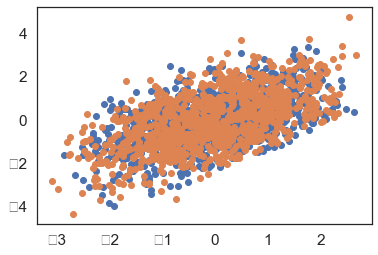

In [363]:
plt.scatter(sig_df.loc[:1000, 'lepton_eta'],sig_df.loc[:1000, 'llbar_new'])
plt.scatter(tt_df.loc[:1000, 'lepton_eta'],tt_df.loc[:1000, 'llbar_new'])